# Modeling and Benchmarking

In [ ]:
!pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 797.8 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np

from tqdm.notebook import tqdm
from sklearn import preprocessing

from rdkit import Chem
from rdkit import RDLogger

from rdkit.Chem import DataStructs
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonCountFP
from rdkit.Chem import rdReducedGraphs
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

import warnings
warnings.filterwarnings('ignore')

class scaler:
    def __init__(self, log=False):
        self.log = log
        self.offset = None
        self.scaler = None

    def fit(self, y):
        # make the values non-negative
        self.offset = np.min([np.min(y), 0.0])
        y = y.reshape(-1, 1) - self.offset
        # scale the input data
        if self.log:
            y = np.log10(y + 1.0)
        self.scaler = preprocessing.StandardScaler().fit(y)

    def transform(self, y):
        y = y.reshape(-1, 1) - self.offset
        # scale the input data
        if self.log:
            y = np.log10(y + 1.0)
        y_scale = self.scaler.transform(y)
        return y_scale

    def inverse_transform(self, y_scale):
        y = self.scaler.inverse_transform(y_scale.reshape(-1, 1))
        if self.log:
            y = 10.0**y - 1.0
        y = y + self.offset
        return y

def count_to_array(fingerprint):
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array

def get_avalon_fingerprints(molecules, n_bits=1024):
    fingerprints = molecules.apply(lambda x: GetAvalonCountFP(x, nBits=n_bits))
    fingerprints = fingerprints.apply(count_to_array)
    return np.stack(fingerprints.values)

def get_morgan_fingerprints(molecules, n_bits=1024, radius=2):
    fingerprints = molecules.apply(lambda x:
        GetHashedMorganFingerprint(x, nBits=n_bits, radius=radius))
    fingerprints = fingerprints.apply(count_to_array)
    return np.stack(fingerprints.values)

def get_erg_fingerprints(molecules):
    fingerprints = molecules.apply(rdReducedGraphs.GetErGFingerprint)
    return np.stack(fingerprints.values)

def get_chosen_descriptors():
    chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
        'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
        'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3',
        'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
        'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2',
        'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount',
        'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA',
        'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge',
        'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge',
        'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
        'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles',
        'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors',
        'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
        'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings',
        'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
        'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
        'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1',
        'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
        'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',
        'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
        'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2',
        'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7',
        'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN',
        'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O',
        'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2',
        'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH',
        'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid',
        'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo',
        'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo',
        'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido',
        'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan',
        'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone',
        'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom',
        'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime',
        'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid',
        'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd',
        'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
        'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
        'fr_unbrch_alkane', 'fr_urea', 'qed']

    return chosen_descriptors

def get_rdkit_features(molecules):
    calculator = MolecularDescriptorCalculator(get_chosen_descriptors())
    X_rdkit = molecules.apply(
        lambda x: np.array(calculator.CalcDescriptors(x)))
    X_rdkit = np.vstack(X_rdkit.values)
    return X_rdkit

def get_fingerprints(smiles):
    RDLogger.DisableLog('rdApp.*')
    molecules = smiles.apply(Chem.MolFromSmiles)

    fingerprints = []
    fingerprints.append(get_morgan_fingerprints(molecules))
    fingerprints.append(get_avalon_fingerprints(molecules))
    fingerprints.append(get_erg_fingerprints(molecules))
    fingerprints.append(get_rdkit_features(molecules))

    return np.concatenate(fingerprints, axis=1)

In [ ]:
!wget -qq https://static-content.springer.com/esm/art%3A10.1007%2Fs11095-015-1800-5/MediaObjects/11095_2015_1800_MOESM5_ESM.sdf
!wget -qq https://static-content.springer.com/esm/art%3A10.1007%2Fs11095-015-1800-5/MediaObjects/11095_2015_1800_MOESM4_ESM.sdf

In [ ]:
import pandas as pd

def read_sdf(sdf_file_path):
    suppl = Chem.SDMolSupplier(sdf_file_path)

    molecules = [mol for mol in suppl if mol is not None]
    print(f"Successfully read {len(molecules)} molecules from {sdf_file_path}")

    data = []
    for mol in suppl:
        if mol is None: continue
        smi = Chem.MolToSmiles(mol)
        props = mol.GetPropsAsDict()
        data.append({'smiles': smi, **props})

    df = pd.DataFrame(data)
    return df

df = read_sdf('11095_2015_1800_MOESM5_ESM.sdf')
df["Stable"].value_counts()

Successfully read 759 molecules from 11095_2015_1800_MOESM5_ESM.sdf


,count
Stable,
0,497
1,262


In [ ]:
X = get_fingerprints(df['smiles'])
y = df["Stable"]

In [ ]:
# hyper-parameters found from a randomized search (RandomizedSearchCV)
# search space:
# param_dist = {
#     'n_estimators': randint(100, 1000),
#     'learning_rate': uniform(0.01, 0.3),
#     'max_depth': randint(3, 10),
#     'subsample': uniform(0.6, 0.4),
#     'colsample_bytree': uniform(0.6, 0.4),
#     'gamma': uniform(0, 0.5),
#     'reg_alpha': uniform(0, 0.5),
#     'reg_lambda': uniform(0, 0.5),
# }

best_params = {
    'colsample_bytree': 0.8012545034320351,
    'gamma': 0.42824492059416114,
    'learning_rate': 0.20760808948568352,
    'max_depth': 6,
    'n_estimators': 115,
    'reg_alpha': 0.03528437370021492,
    'reg_lambda': 0.3212096391031578,
    'subsample': 0.6106045242166487
}

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy = []
roc_auc_scores = []
trained_models = []
for train_index, val_index in cv.split(X, y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_train_fold, y_train_fold)

    y_pred_label = model.predict(X_val_fold)
    accuracy.append(accuracy_score(y_val_fold, y_pred_label))

    y_pred_prob_fold = model.predict_proba(X_val_fold)[:, 1]

    roc_auc_fold = roc_auc_score(y_val_fold, y_pred_prob_fold)
    roc_auc_scores.append(roc_auc_fold)
    trained_models.append(model)

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f"Accuracy for each fold: {accuracy}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation of Accuracy: {std_accuracy:.4f}\n")

mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)

print(f"ROC AUC scores for each fold: {roc_auc_scores}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"Standard deviation of ROC AUC: {std_roc_auc:.4f}")

Accuracy for each fold: [0.8421052631578947, 0.7894736842105263, 0.8289473684210527, 0.8092105263157895, 0.8278145695364238]
Mean Accuracy: 0.8195
Standard deviation of Accuracy: 0.0183

ROC AUC scores for each fold: [0.9094230769230769, 0.8476923076923076, 0.8713550600343053, 0.887745378311416, 0.8723776223776223]
Mean ROC AUC: 0.8777
Standard deviation of ROC AUC: 0.0204


In [ ]:
test_df = read_sdf('11095_2015_1800_MOESM4_ESM.sdf')
test_df["Stable"].value_counts()

Successfully read 30 molecules from 11095_2015_1800_MOESM4_ESM.sdf


,count
Stable,
1,27
0,3


In [ ]:
X = get_fingerprints(test_df['smiles'])
y = test_df["Stable"]

In [ ]:
best_xgb_model = trained_models[np.argmax(roc_auc_scores)]

test_pred = best_xgb_model.predict(X)

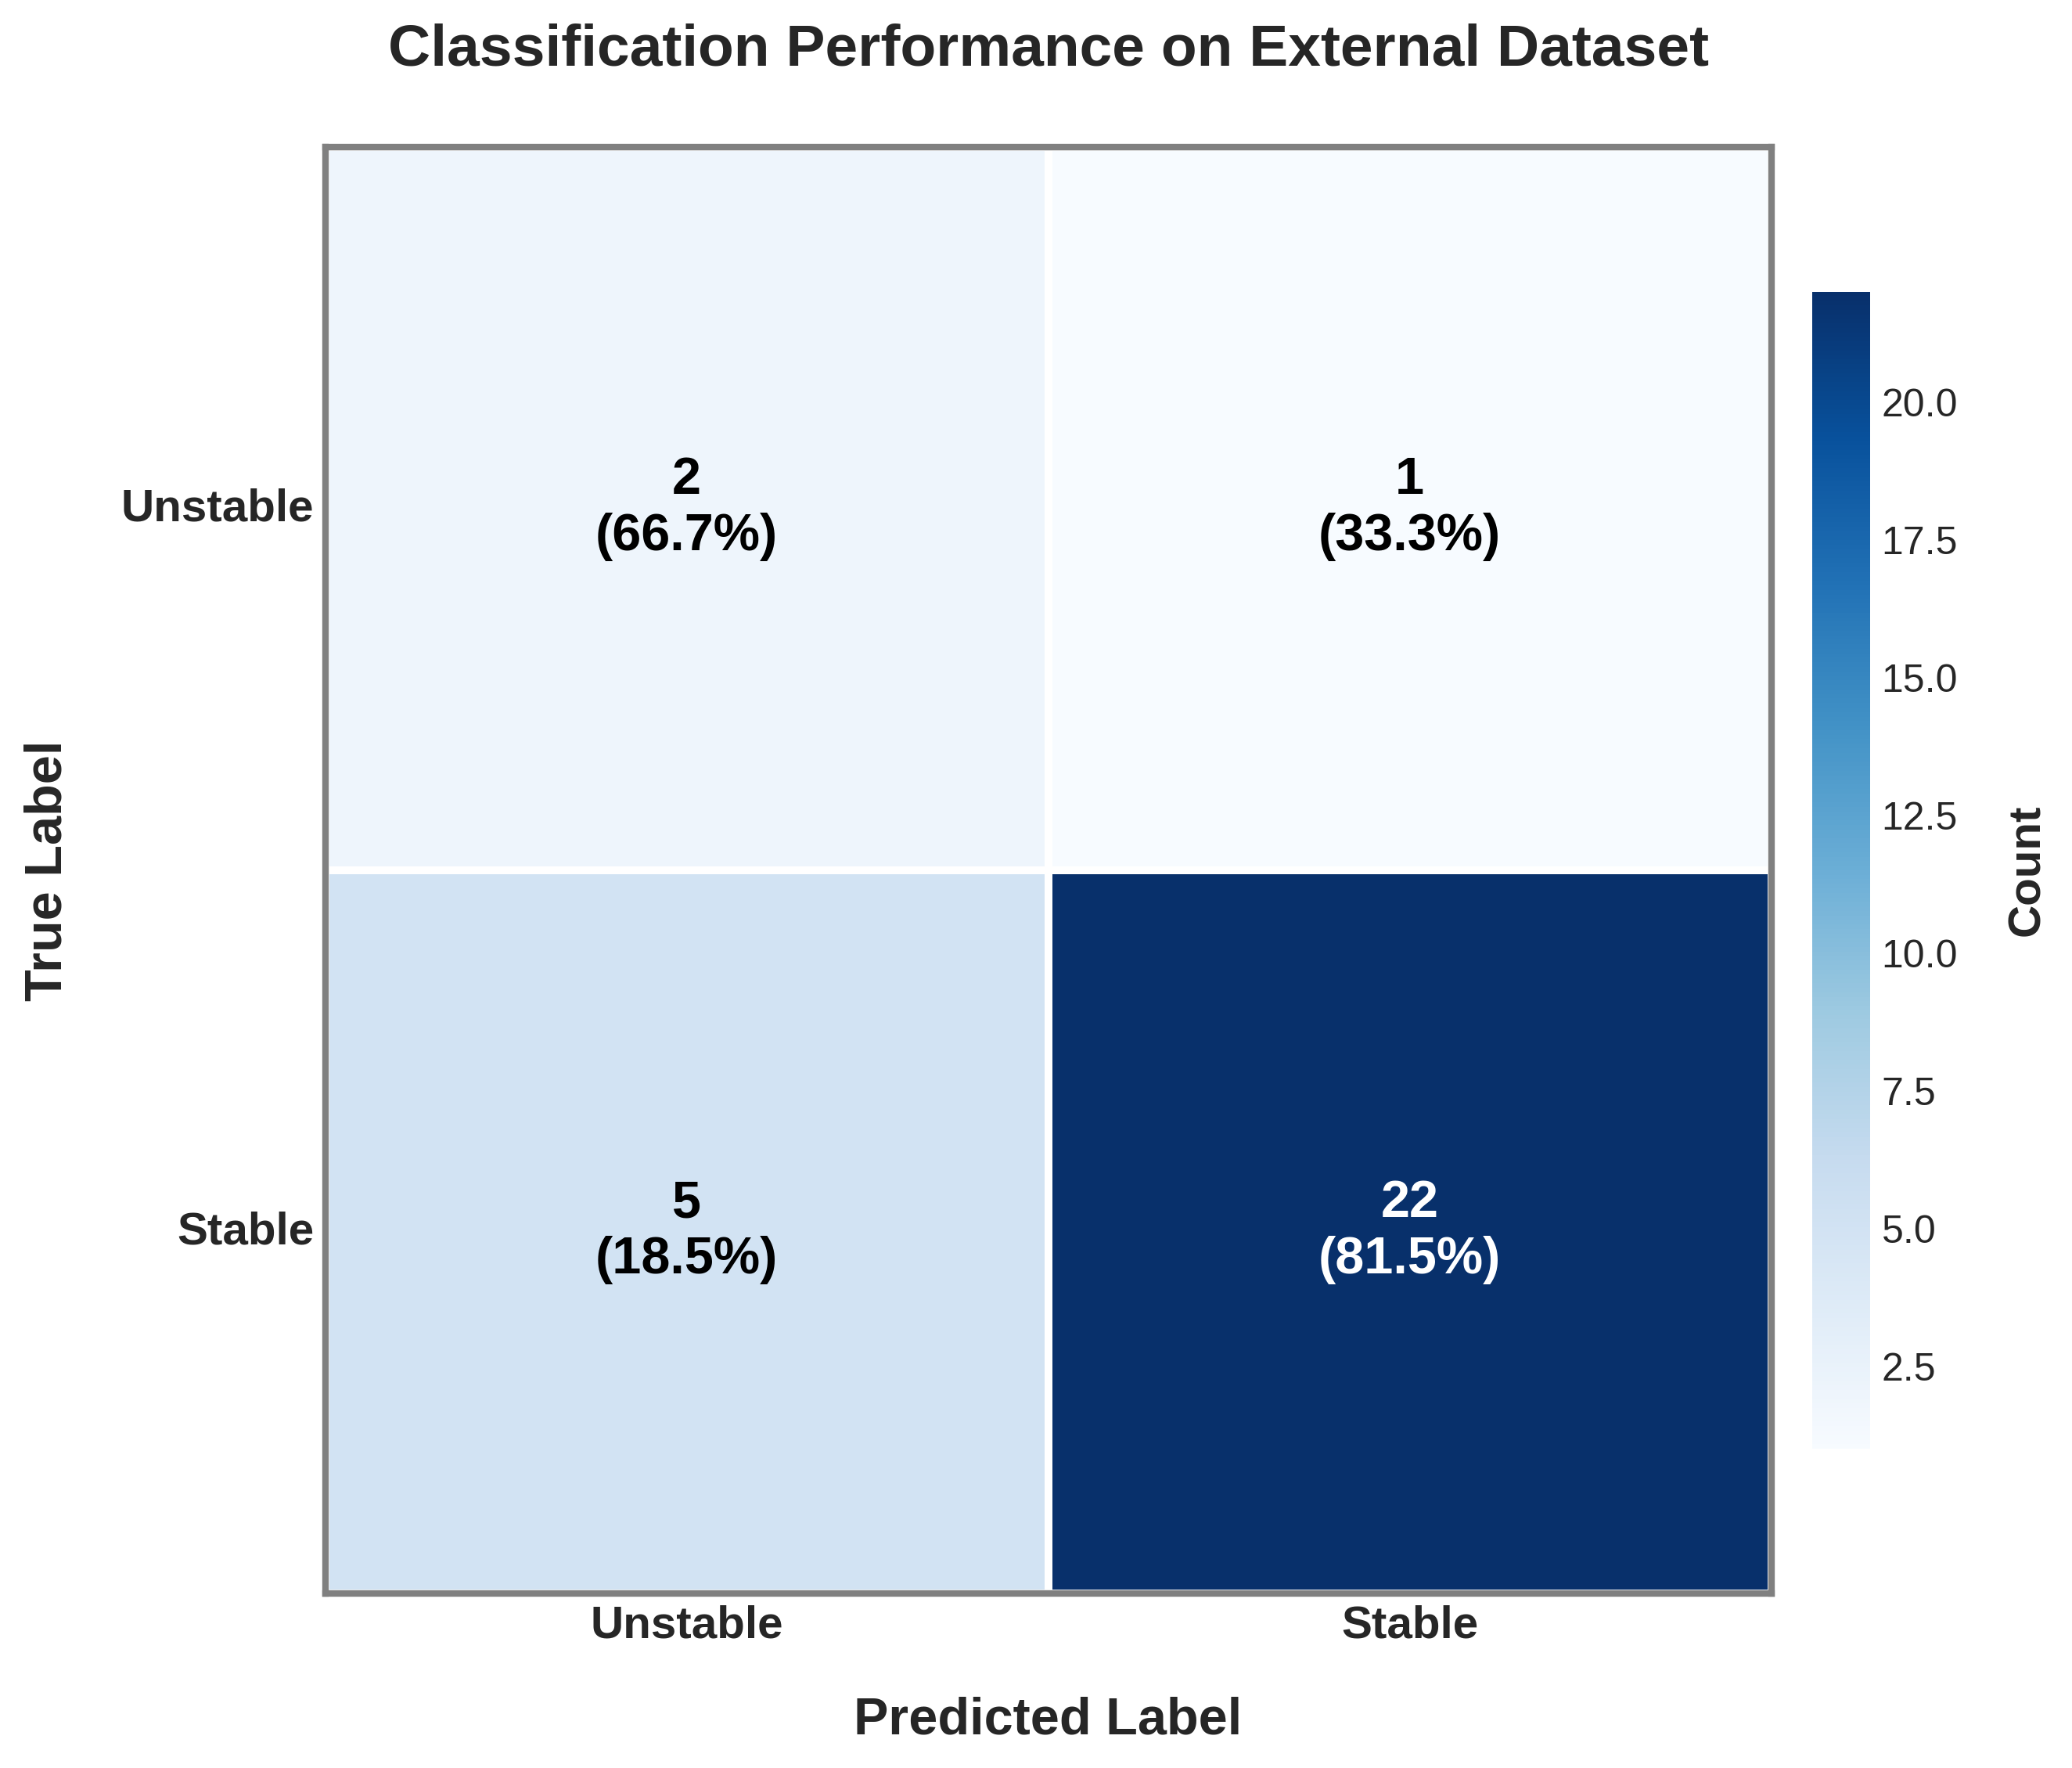

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')

# Create confusion matrix
cm = confusion_matrix(y, test_pred)

# Calculate performance metrics
accuracy = accuracy_score(y, test_pred)
precision = precision_score(y, test_pred, average='weighted')
recall = recall_score(y, test_pred, average='weighted')
f1 = f1_score(y, test_pred, average='weighted')

# Create figure with higher DPI for crisp output
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Create custom colormap - professional blue gradient
colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
n_bins = 256
cmap = sns.blend_palette(colors, n_colors=n_bins, as_cmap=True)

# Create the heatmap with enhanced styling
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=cmap,
            cbar=True,
            cbar_kws={'shrink': 0.8, 'aspect': 20, 'pad': 0.02},
            xticklabels=['Unstable', 'Stable'],
            yticklabels=['Unstable', 'Stable'],
            square=True,
            linewidths=2,
            linecolor='white',
            annot_kws={'size': 20, 'weight': 'bold', 'color': 'white'},
            ax=ax)

# Enhanced labels and title
ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('True Label', fontsize=16, fontweight='bold', labelpad=15)
ax.set_title('Classification Performance on External Dataset',
             fontsize=18, fontweight='bold', pad=25)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=14, width=1.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontweight='bold')

# Calculate percentages for each cell
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Add percentage annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                fontsize=16, fontweight='bold',
                color='white' if cm[i, j] > cm.max() * 0.5 else 'black')

# Clear the default annotations to avoid overlap
for text in ax.texts:
    if len(text.get_text()) < 5:  # Remove simple number annotations
        text.set_visible(False)

# Add performance metrics text box
# textstr = f'Performance Metrics:\nAccuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}\n\nSample Size: {cm.sum()}'
# props = dict(boxstyle='round,pad=0.8', facecolor='lightgray', alpha=0.9, edgecolor='gray')
# ax.text(1.25, 0.7, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='center', bbox=props, fontfamily='monospace')

# Add classification details
true_neg, false_pos, false_neg, true_pos = cm.ravel()
specificity = true_neg / (true_neg + false_pos)
sensitivity = true_pos / (true_pos + false_neg)

# detail_text = f'Detailed Metrics:\nTrue Positives: {true_pos}\nTrue Negatives: {true_neg}\nFalse Positives: {false_pos}\nFalse Negatives: {false_neg}\n\nSensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}'
# props2 = dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.9, edgecolor='steelblue')
# ax.text(1.25, 0.5, detail_text, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=props2, fontfamily='monospace')

# Customize colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Count', fontsize=14, fontweight='bold', labelpad=15)
cbar.ax.tick_params(labelsize=12, width=1.2)

# Add subtle border around the heatmap
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('gray')

# Adjust layout to accommodate the metrics boxes
plt.subplots_adjust(right=1)

# For publication, save with high quality
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
# plt.savefig('confusion_matrix.pdf', bbox_inches='tight',
#             facecolor='white', edgecolor='none')

plt.show()

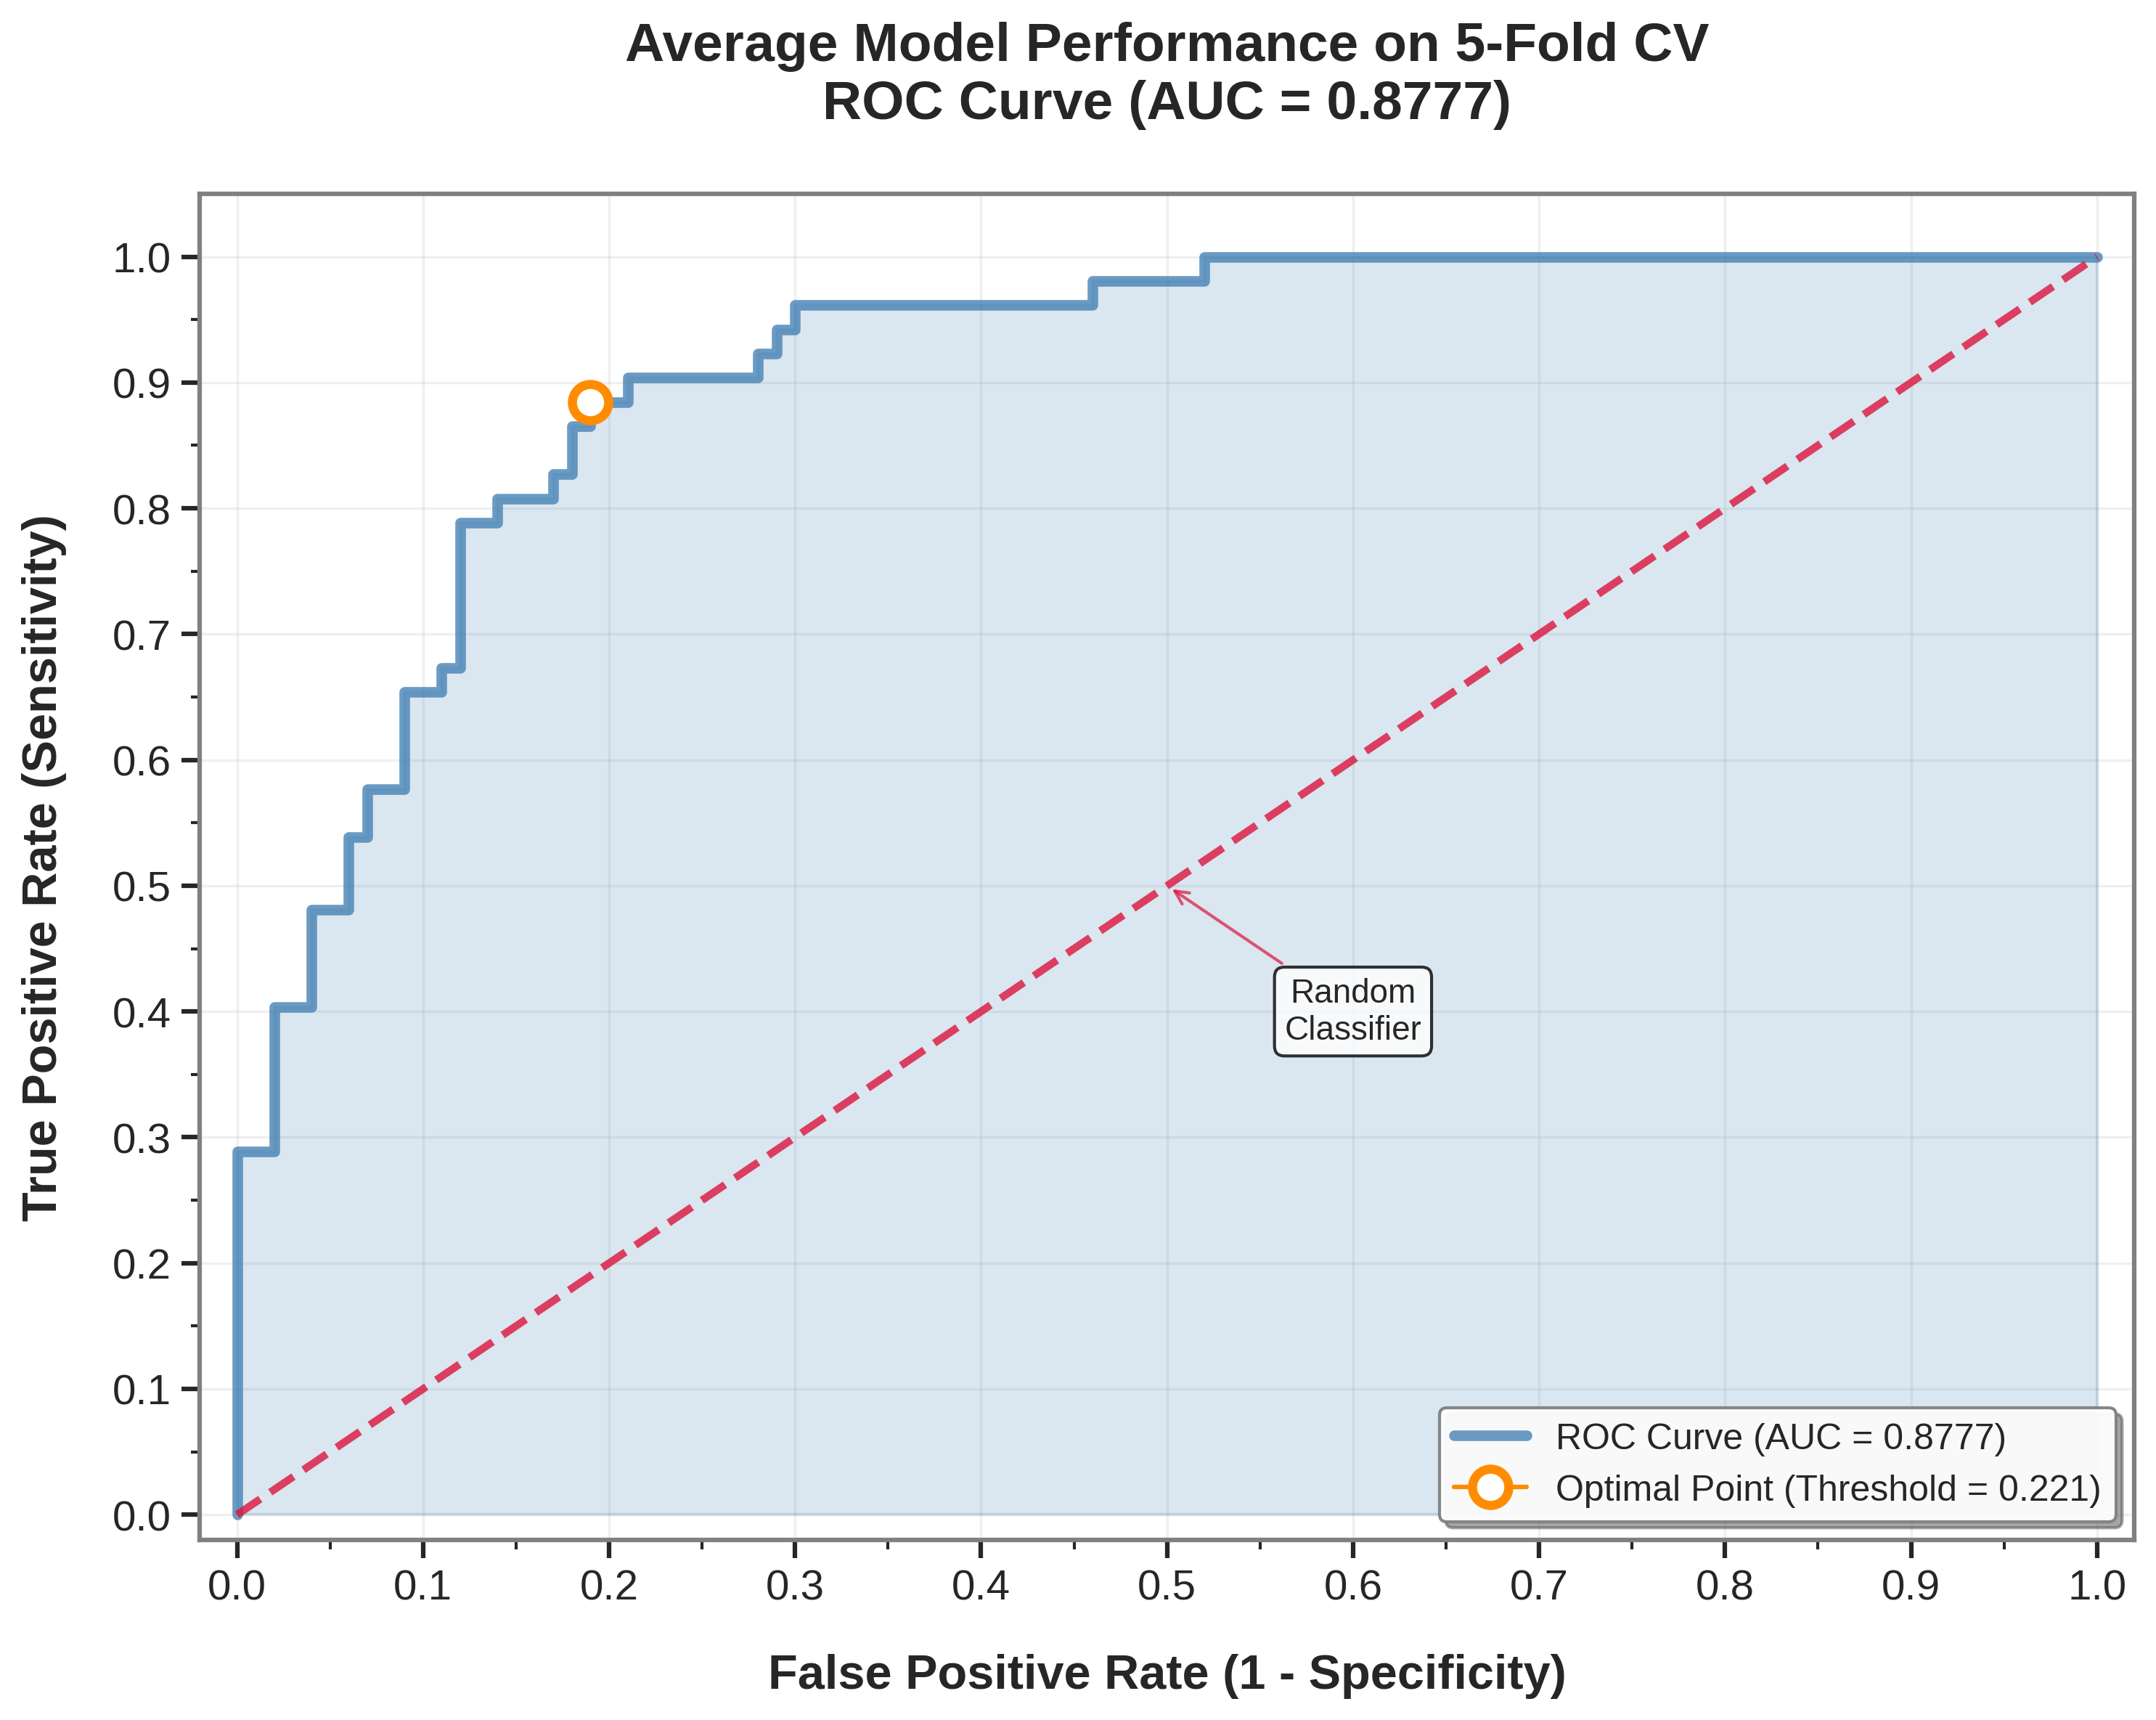

ROC CURVE ANALYSIS RESULTS
AUC Score: 0.9094
Performance Classification: Excellent
Optimal Threshold: 0.2207
Optimal Sensitivity (TPR): 0.8846
Optimal Specificity (1-FPR): 0.8100
Optimal Point: (0.1900, 0.8846)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred_prob_fold)
roc_auc = auc(fpr, tpr)

# Calculate additional metrics for optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

# Create figure with higher DPI for crisp output
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Plot ROC curve with enhanced styling
ax.plot(fpr, tpr,
        color='steelblue',
        linewidth=3.5,
        alpha=0.8,
        label=f'ROC Curve (AUC = 0.8777)')

# Fill area under the curve
ax.fill_between(fpr, tpr, alpha=0.2, color='steelblue',
                # label=f'AUC = {roc_auc:.3f}',
                )

# Plot diagonal reference line (random classifier)
ax.plot([0, 1], [0, 1],
        color='crimson',
        linewidth=2.5,
        linestyle='--',
        alpha=0.8,
        # label='Random Classifier (AUC = 0.500)',
        )

# Mark optimal operating point
ax.plot(optimal_fpr, optimal_tpr,
        marker='o',
        markersize=12,
        color='darkorange',
        markerfacecolor='white',
        markeredgewidth=3,
        label=f'Optimal Point (Threshold = {optimal_threshold:.3f})',
        )

# Enhanced labels and title
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_title('Average Model Performance on 5-Fold CV\nROC Curve (AUC = 0.8777)',
             fontsize=18, fontweight='bold', pad=25)

# Set axis limits with slight padding
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.05])

# Customize grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)

# Add performance interpretation
if roc_auc >= 0.9:
    performance = "Excellent"
    color = "darkgreen"
elif roc_auc >= 0.8:
    performance = "Good"
    color = "green"
elif roc_auc >= 0.7:
    performance = "Fair"
    color = "orange"
elif roc_auc >= 0.6:
    performance = "Poor"
    color = "red"
else:
    performance = "Fail"
    color = "darkred"

# Add comprehensive statistics text box
# textstr = f'Performance Metrics:\nAUC: {roc_auc:.4f}\nClassification: {performance}\n\nOptimal Threshold: {optimal_threshold:.3f}\nSensitivity: {optimal_tpr:.3f}\nSpecificity: {1-optimal_fpr:.3f}\n\nSample Size: {len(y_val_fold)}'
# props = dict(boxstyle='round,pad=0.8', facecolor='lightgray', alpha=0.9, edgecolor='gray')
# ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=props, fontfamily='monospace')

# Add interpretation guide
# guide_text = f'AUC Interpretation:\n≥ 0.90: Excellent\n≥ 0.80: Good\n≥ 0.70: Fair\n≥ 0.60: Poor\n< 0.60: Fail\n\nCurrent: {performance}'
# props2 = dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.9, edgecolor='steelblue')
# ax.text(0.98, 0.02, guide_text, transform=ax.transAxes, fontsize=11,
#         verticalalignment='bottom', horizontalalignment='right',
#         bbox=props2, fontfamily='monospace')

# Enhanced legend
ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True,
          fontsize=12, framealpha=0.95, edgecolor='gray')

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)
ax.tick_params(axis='both', which='minor', width=1, length=3)

# Add minor ticks for better precision
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.05, 0.05), minor=True)
ax.set_yticks(np.arange(0, 1.05, 0.05), minor=True)

# Customize spines
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('gray')

# Add 45-degree line annotation
ax.annotate('Random\nClassifier', xy=(0.5, 0.5), xytext=(0.6, 0.4),
            fontsize=11, ha='center', va='center',
            arrowprops=dict(arrowstyle='->', color='crimson', alpha=0.7),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Tight layout for better spacing
plt.tight_layout()

# For publication, save with high quality
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
# plt.savefig('roc_curve.pdf', bbox_inches='tight',
#             facecolor='white', edgecolor='none')

plt.show()

# Print comprehensive results
print("="*50)
print("ROC CURVE ANALYSIS RESULTS")
print("="*50)
print(f"AUC Score: {roc_auc:.4f}")
print(f"Performance Classification: {performance}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Optimal Sensitivity (TPR): {optimal_tpr:.4f}")
print(f"Optimal Specificity (1-FPR): {1-optimal_fpr:.4f}")
print(f"Optimal Point: ({optimal_fpr:.4f}, {optimal_tpr:.4f})")
print("="*50)

In [ ]:
import joblib

joblib.dump(best_xgb_model, 'best_xgb_model_MLM.pkl')
print("best_xgb_model saved successfully!")

best_xgb_model saved successfully!


In [64]:
model = joblib.load('best_xgb_model_MLM.pkl')

# Prediction for Experimental Data

In [65]:
exp_df = pd.read_csv("/content/Hits for solubility and mouse microsomal half-life predictions.csv")
exp_X = get_fingerprints(exp_df["SMILE"])

y_pred_label = model.predict(exp_X)
y_pred_prob = model.predict_proba(exp_X)[:, 1]

df["prediction"] = y_pred_label
df["confidence"] = y_pred_prob

df_sorted = df.sort_values(by='confidence', ascending=False)
df_sorted["confidence"] = df_sorted["confidence"].round(2)
df_sorted["confidence"] = df_sorted["confidence"].apply(lambda x: 1 - x if x < 0.5 else x)
df_sorted

,ID,Drug Name,SMILE,prediction,confidence
6,17,Afatinib,O=C(NC1=C(C=C2C(C(NC3=CC(Cl)=C(C=C3)F)=NC=N2)=...,1,0.96
1,7,Tanzisertib,O[C@H]1CC[C@H](NC2=NC=C3N=C(NC4=C(F)C=C(F)C=C4...,1,0.94
8,19,SGI-1776,CN1CCC(CC1)CNC2=NN3C(C=C2)=NC=C3C4=CC=CC(OC(F)...,1,0.86
3,10,ARRY-380,CC1=CC(NC2=C3C=C(NC4=NC(C)(C)CO4)C=CC3=NC=N2)=...,1,0.84
10,21,Dasatinib,O=C(C1=CN=C(S1)NC2=NC(C)=NC(N3CCN(CC3)CCO)=C2)...,1,0.68
5,16,Ibrutinib,C=CC(N1C[C@H](N2N=C(C3=CC=C(OC4=CC=CC=C4)C=C3)...,1,0.58
13,24,Vandetanib,FC1=CC(Br)=CC=C1NC2=NC=NC3=CC(OCC4CCN(CC4)C)=C...,0,0.51
11,22,Pazopanib,O=S(C1=CC(NC2=NC=CC(N(C3=CC4=NN(C(C)=C4C=C3)C)...,0,0.58
15,26,Dabrafenib,CC(C)(C)C1=NC(C2=C(F)C(NS(C3=C(F)C=CC=C3F)(=O)...,0,0.60
4,15,AEE-788,C[C@H](C1=CC=CC=C1)NC2=C(C=C3C(C=C4)=CC=C4CN5C...,0,0.60


In [66]:
df_sorted.to_csv("mlm_pred.csv", index=False)